In [1]:
import util
import vqe_class
import ansatz_circ

import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mpl
from matplotlib import animation

from qiskit.primitives import Estimator,Sampler
from qiskit_aer import AerSimulator
from qiskit.algorithms.optimizers import COBYLA,NFT,GradientDescent,ADAM

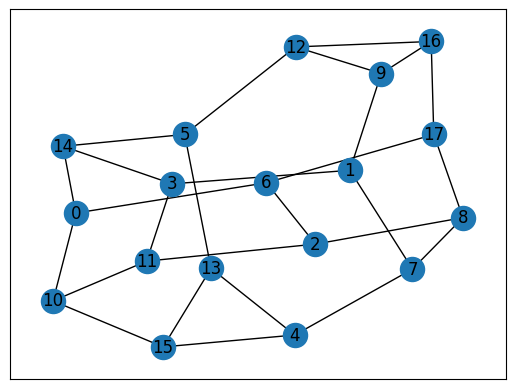

In [2]:
n_vertex=18
graph=nx.random_regular_graph(3,n_vertex)
#p=0.6
#graph=nx.gnp_random_graph(n_vertex,p)
#graph=nx.barabasi_albert_graph(n_vertex,4)
#graph=util.generate_random_graph(n_vertex,0.5)
sum=0
# Assign random weights to edges
for edge in graph.edges():
    #a=np.random.rand(1)[0]
    a=1
    sum+=a
    #graph.edges[edge]['weight'] = np.random.rand()
    graph.edges[edge]['weight'] = 1
nx.draw_networkx(graph)

In [3]:
max=np.max(list(util.Hamiltonian_spectrum(graph).values()))

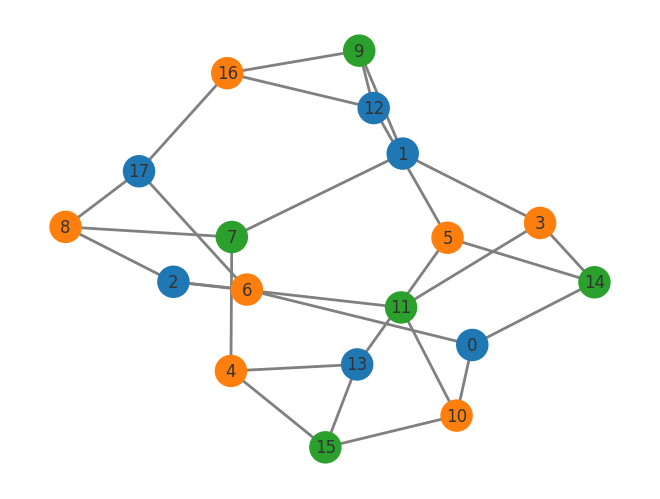

In [4]:
graph_coloring = nx.greedy_color(graph)

unique_colors = set(graph_coloring.values())

# Assign colors to nodes based on the greedy coloring
graph_color_to_mpl_color = dict(zip(unique_colors, mpl.TABLEAU_COLORS))
node_colors = [graph_color_to_mpl_color[graph_coloring[n]] for n in graph.nodes()]

pos = nx.spring_layout(graph, seed=14)
nx.draw(
    graph,
    pos,
    with_labels=True,
    node_size=500,
    node_color=node_colors,
    edge_color="grey",
    font_size=12,
    font_color="#333333",
    width=2,
)

In [5]:
nft=NFT(maxiter=1000, maxfev=1024, disp=False, reset_interval=1000, options=None)
cobyla=COBYLA(maxiter=1000, disp=True, rhobeg=0.01, tol=0.01, options=None)
adam=ADAM(maxiter=300, tol=1e-02, lr=0.5, beta_1=0.98, beta_2=0.99, noise_factor=1e-08, eps=1e-2, amsgrad=True, snapshot_dir=None)
g_d=GradientDescent(maxiter=300,learning_rate=0.01, tol=0.01, callback=None, perturbation=None)



estimator_dens= AerSimulator(method='density_matrix')
estimator_state= AerSimulator(method='statevector')
estimator = Estimator()
sampler = Sampler()


In [6]:
n_vertex=len(graph.nodes())
num_qubits=len(util.operator_vertex(graph)[0][0])
alpha=np.sqrt(len(graph.nodes()))

ans_ent=ansatz_circ.ansatz_efficient(num_qubits,6)
ans=ansatz_circ.sep_ansatz(graph,4)
circuits=ansatz_circ.multibasis_ansatz(ans)
circuits_ent=ansatz_circ.multibasis_ansatz(ans_ent)

6


In [7]:
stat=4
res_gw=[]
for i in range (stat):


    gw_cut=util.gw_cut(graph)
    res_gw.append(gw_cut/max)
print(np.mean(np.array(res_gw)))
print(np.std(np.array(res_gw)))

0.9791666666666666
0.03608439182435163


In [8]:
stat=4
res_quad_sep_warm=[]
res_quad_ent_warm=[]
res_nonlin_sep_warm=[]
res_nonlin_ent_warm=[]
for i in range (stat):


    gw_cut=util.gw_cut(graph)
    beta=1
    v=gw_cut
    gamma=0
    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=1, tol=0.01, options=None)
    intermediate_info_init= []
    def callback(data):
        intermediate_info_init.append(data)
    qrao=vqe_class.QRAO_initial_state_VQE(graph,sampler,circuits,cobyla,max,alpha,beta,v,gamma,shots=None,initial_parameters=None,callback=callback)
    result_init=qrao.compute_minimum_eigenvalue(min)
    new_init_sep=result_init.optimal_parameters


    qrao=vqe_class.QRAO_initial_state_VQE(graph,sampler,circuits_ent,cobyla,max,alpha,beta,v,gamma,shots=None,initial_parameters=None,callback=callback)
    result_init_ent=qrao.compute_minimum_eigenvalue(min)
    new_init_ent=result_init_ent.optimal_parameters


    v=0
    gamma=0
    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    intermediate_info_qrao= []
    def callback(data):
        intermediate_info_qrao.append(data)
    qrao=vqe_class.QRAO_quadratic_VQE(graph,sampler,circuits,cobyla,max,alpha,beta,v,gamma,shots=None,initial_parameters=new_init_sep,callback=callback)
    result_qrao= qrao.compute_minimum_eigenvalue(min)
    new_init=result_qrao.optimal_parameters
    v=gw_cut/2
    gamma=1
    cobyla=COBYLA(maxiter=1000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    #intermediate_info_qrao= []
    def callback(data):
        intermediate_info_qrao.append(data)
    qrao=vqe_class.QRAO_quadratic_VQE(graph,sampler,circuits,cobyla,max,alpha,beta,v,gamma,shots=None,initial_parameters=new_init,callback=callback)
    result_qrao= qrao.compute_minimum_eigenvalue(min)
    res_quad_sep_warm.append(result_qrao.eigenvalue/max)
    


    v=gw_cut
    gamma=0
    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    intermediate_info_qrao_non_linear= []
    def callback(data):
        intermediate_info_qrao_non_linear.append(data)
    qrao=vqe_class.QRAO_nonlinear_VQE(graph,sampler,circuits,cobyla,max,alpha,beta,v,gamma,shots=None,initial_parameters=new_init_sep,callback=callback)
    result_qrao_non= qrao.compute_minimum_eigenvalue(min)
    new_init=result_qrao_non.optimal_parameters


    v=gw_cut/2
    gamma=1

    cobyla=COBYLA(maxiter=1000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    #intermediate_info_qrao_non_linear= []
    def callback(data):
        intermediate_info_qrao_non_linear.append(data)
    qrao=vqe_class.QRAO_nonlinear_VQE(graph,sampler,circuits,cobyla,max,alpha,beta,v,gamma,shots=None,initial_parameters=new_init,callback=callback)
    result_qrao_non= qrao.compute_minimum_eigenvalue(min)
    res_nonlin_sep_warm.append(result_qrao_non.eigenvalue/max)







    v=0
    gamma=0
    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    intermediate_info_qrao= []
    def callback(data):
        intermediate_info_qrao.append(data)
    qrao=vqe_class.QRAO_quadratic_VQE(graph,sampler,circuits_ent,cobyla,max,alpha,beta,v,gamma,shots=None,initial_parameters=new_init_ent,callback=callback)
    result_qrao= qrao.compute_minimum_eigenvalue(min)
    new_init=result_qrao.optimal_parameters
    v=gw_cut/2
    gamma=1
    cobyla=COBYLA(maxiter=1000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    #intermediate_info_qrao= []
    def callback(data):
        intermediate_info_qrao.append(data)
    qrao=vqe_class.QRAO_quadratic_VQE(graph,sampler,circuits_ent,cobyla,max,alpha,beta,v,gamma,shots=None,initial_parameters=new_init,callback=callback)
    result_qrao= qrao.compute_minimum_eigenvalue(min)
    res_quad_ent_warm.append(result_qrao.eigenvalue/max)
    


    v=gw_cut
    gamma=0
    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    intermediate_info_qrao_non_linear= []
    def callback(data):
        intermediate_info_qrao_non_linear.append(data)
    qrao=vqe_class.QRAO_nonlinear_VQE(graph,sampler,circuits_ent,cobyla,max,alpha,beta,v,gamma,shots=None,initial_parameters=new_init_ent,callback=callback)
    result_qrao_non= qrao.compute_minimum_eigenvalue(min)
    new_init=result_qrao_non.optimal_parameters


    v=gw_cut/2
    gamma=1

    cobyla=COBYLA(maxiter=1000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    #intermediate_info_qrao_non_linear= []
    def callback(data):
        intermediate_info_qrao_non_linear.append(data)
    qrao=vqe_class.QRAO_nonlinear_VQE(graph,sampler,circuits_ent,cobyla,max,alpha,beta,v,gamma,shots=None,initial_parameters=new_init,callback=callback)
    result_qrao_non= qrao.compute_minimum_eigenvalue(min)
    res_nonlin_ent_warm.append(result_qrao_non.eigenvalue/max)

approxs
0.5630232899194704
-0.5647242359442387
0.625
approxs
0.5634373047377537
-0.5663786306167403
0.6666666666666666
approxs
0.5615064634341105
-0.5584575612272491
0.6666666666666666
approxs
0.5604248603904634
-0.5538341308527427
0.5
approxs
0.565755670877459
-0.5760079765051989
0.625
approxs
0.5657806774121186
-0.5762051857463949
0.5833333333333334
approxs
0.5675256742035738
-0.5829793972713991
0.625
approxs
0.5646361073936272
-0.5714283400609722
0.625
approxs
0.5676599771821677
-0.5830165902766956
0.625
approxs
0.570082069213358
-0.5903257360391506
0.625
approxs
0.5755451625170739
-0.6037212482188513
0.625
approxs
0.5755287780274898
-0.603650906293464
0.625
approxs
0.5756537633175205
-0.6025530220101215
0.625
approxs
0.5740605868401372
-0.5979064666977617
0.625
approxs
0.5786379589489411
-0.6072555706965523
0.625
approxs
0.5786388606057177
-0.6072611369938832
0.625
approxs
0.5817581954508398
-0.610489204054535
0.625
approxs
0.5841184910126168
-0.6207151815650173
0.6666666666666666


KeyboardInterrupt: 

In [ ]:
print(np.mean(np.array(res_quad_sep_warm)))
print(np.std(np.array(res_quad_sep_warm)))

print(np.mean(np.array(res_quad_ent_warm)))
print(np.std(np.array(res_quad_ent_warm)))

0.8913043478260869
0.021739130434782594
0.8478260869565217
0.04861017342390844


In [ ]:
print(np.mean(np.array(res_nonlin_sep_warm)))
print(np.std(np.array(res_nonlin_sep_warm)))

print(np.mean(np.array(res_nonlin_ent_warm)))
print(np.std(np.array(res_nonlin_ent_warm)))

0.9130434782608695
0.0
0.9130434782608695
0.0


In [ ]:
res_quad_sep=[]
res_quad_ent=[]
res_nonlin_sep=[]
res_nonlin_ent=[]
for i in range (stat):
    v=0
    gamma=0
    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    intermediate_info_qrao= []
    def callback(data):
        intermediate_info_qrao.append(data)
    qrao=vqe_class.QRAO_quadratic_VQE(graph,sampler,circuits,cobyla,max,alpha,beta,v,gamma,shots=None,initial_parameters=None,callback=callback)
    result_qrao= qrao.compute_minimum_eigenvalue(min)
    new_init=result_qrao.optimal_parameters
    v=gw_cut/2
    gamma=1
    cobyla=COBYLA(maxiter=1000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    def callback(data):
        intermediate_info_qrao.append(data)
    qrao=vqe_class.QRAO_quadratic_VQE(graph,sampler,circuits,cobyla,max,alpha,beta,v,gamma,shots=None,initial_parameters=new_init,callback=callback)
    result_qrao= qrao.compute_minimum_eigenvalue(min)
    res_quad_sep.append(result_qrao.eigenvalue/max)
    


    v=gw_cut
    gamma=0
    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    intermediate_info_qrao_non_linear= []
    def callback(data):
        intermediate_info_qrao_non_linear.append(data)
    qrao=vqe_class.QRAO_nonlinear_VQE(graph,sampler,circuits,cobyla,max,alpha,beta,v,gamma,shots=None,initial_parameters=None,callback=callback)
    result_qrao_non= qrao.compute_minimum_eigenvalue(min)
    new_init=result_qrao_non.optimal_parameters


    v=gw_cut/2
    gamma=1

    cobyla=COBYLA(maxiter=1000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    #intermediate_info_qrao_non_linear= []
    def callback(data):
        intermediate_info_qrao_non_linear.append(data)
    qrao=vqe_class.QRAO_nonlinear_VQE(graph,sampler,circuits,cobyla,max,alpha,beta,v,gamma,shots=None,initial_parameters=new_init,callback=callback)
    result_qrao_non= qrao.compute_minimum_eigenvalue(min)
    res_nonlin_sep.append(result_qrao_non.eigenvalue/max)







    v=0
    gamma=0
    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    intermediate_info_qrao= []
    def callback(data):
        intermediate_info_qrao.append(data)
    qrao=vqe_class.QRAO_quadratic_VQE(graph,sampler,circuits_ent,cobyla,max,alpha,beta,v,gamma,shots=None,initial_parameters=None,callback=callback)
    result_qrao= qrao.compute_minimum_eigenvalue(min)
    new_init=result_qrao.optimal_parameters
    v=gw_cut/2
    gamma=1
    cobyla=COBYLA(maxiter=1000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    #intermediate_info_qrao= []
    def callback(data):
        intermediate_info_qrao.append(data)
    qrao=vqe_class.QRAO_quadratic_VQE(graph,sampler,circuits_ent,cobyla,max,alpha,beta,v,gamma,shots=None,initial_parameters=new_init,callback=callback)
    result_qrao= qrao.compute_minimum_eigenvalue(min)
    res_quad_ent.append(result_qrao.eigenvalue/max)
    


    v=gw_cut
    gamma=0
    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    intermediate_info_qrao_non_linear= []
    def callback(data):
        intermediate_info_qrao_non_linear.append(data)
    qrao=vqe_class.QRAO_nonlinear_VQE(graph,sampler,circuits_ent,cobyla,max,alpha,beta,v,gamma,shots=None,initial_parameters=None,callback=callback)
    result_qrao_non= qrao.compute_minimum_eigenvalue(min)
    new_init=result_qrao_non.optimal_parameters


    v=gw_cut/2
    gamma=1

    cobyla=COBYLA(maxiter=1000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    #intermediate_info_qrao_non_linear= []
    def callback(data):
        intermediate_info_qrao_non_linear.append(data)
    qrao=vqe_class.QRAO_nonlinear_VQE(graph,sampler,circuits_ent,cobyla,max,alpha,beta,v,gamma,shots=None,initial_parameters=new_init,callback=callback)
    result_qrao_non= qrao.compute_minimum_eigenvalue(min)
    res_nonlin_ent.append(result_qrao_non.eigenvalue/max)

approxs
0.5572644490481133
-0.5364937433303939
0.5652173913043478
approxs
0.5560732153808975
-0.5417905685979619
0.5652173913043478
approxs
0.5594386085610362
-0.5423710406202146
0.5652173913043478
approxs
0.5579680350566545
-0.5359211497058814
0.6086956521739131
approxs
0.5583772147852457
-0.5388832487488753
0.5652173913043478
approxs
0.5594841204115355
-0.5417115598912635
0.5652173913043478
approxs
0.5609408744962893
-0.5485736006817371
0.5652173913043478
approxs
0.5589019210603037
-0.5435029974199607
0.6086956521739131
approxs
0.5600184035223602
-0.5408760097660885
0.6086956521739131
approxs
0.5583629350290902
-0.540797128758418
0.6086956521739131
approxs
0.5601584147862699
-0.5475822013675208
0.6086956521739131
approxs
0.5609973652461197
-0.548938428415756
0.5652173913043478
approxs
0.5621474670547382
-0.5536124169966513
0.5652173913043478
approxs
0.5621367836185018
-0.5571079029787558
0.5652173913043478
approxs
0.5635905957007649
-0.5561447958846936
0.5652173913043478
approxs
0.56

In [ ]:
print(np.mean(np.array(res_quad_sep)))
print(np.std(np.array(res_quad_sep)))

print(np.mean(np.array(res_quad_ent)))
print(np.std(np.array(res_quad_ent)))

0.8804347826086956
0.018826639212705176
0.8478260869565217
0.021739130434782594


In [ ]:
print(np.mean(np.array(res_nonlin_sep)))
print(np.std(np.array(res_nonlin_sep)))

print(np.mean(np.array(res_nonlin_ent)))
print(np.std(np.array(res_nonlin_ent)))

0.8695652173913043
0.04347826086956519
0.9130434782608695
0.0
